In [1]:
import collections
import os
import json
import logging
import string
import re

from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import networkx as nx

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.codon_bias.process_domains import compute_protein_domain_scores

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")
logger = logging.getLogger(__name__)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Match

In [4]:
def compute_match_score(engine):
    q = """
    select assembly_accession from assembly_source
    """
    assembly_accessions = pd.read_sql(q, engine)['assembly_accession'].values
    
    count = 0
    for assembly in assembly_accessions:
        protein_domains_path = os.path.join(
            os.getcwd(), 
            f'data/domains/codon_bias/pfam/{assembly}_protein_domains.csv',
        )
        if os.path.isfile(protein_domains_path):
            count += 1
            
    return count, 100 * count / len(assembly_accessions)

In [5]:
compute_match_score(engine)

(1217, 37.08104814137721)

## Thermotoga maritima

In [6]:
species_taxid = 2336

In [160]:
q = """
select assembly_accession, species_taxid from assembly_source
where species_taxid = ?
"""
assembly_accession = pd.read_sql(q, engine, params=(species_taxid,))['assembly_accession'].iloc[0]
assembly_accession

'GCA_000008545.1'

In [161]:
protein_domains_path = os.path.join(
    os.getcwd(), 
    f'data/domains/codon_bias/pfam/{assembly_accession}_protein_domains.csv',
)
thermotoga_domains = pd.read_csv(protein_domains_path)
thermotoga_domains.head(20)

,assembly_accession,protein_id,record_type,pfam_query,pfam_accession,protein_label,below_threshold
0,GCA_000008545.1,AAD36281.1,pfam,MrpF_PhaF,PF04066.13,conserved-hypothetical-protein,False
1,GCA_000008545.1,AAD36013.1,pfam,Mrr_cat,PF04471.12,conserved-hypothetical-protein,False
2,GCA_000008545.1,AAD35343.1,pfam,Mrr_cat,PF04471.12,conserved-hypothetical-protein,False
3,GCA_000008545.1,AAD35100.1,pfam,MR_MLE_C,PF13378.6,muconate-cycloisomerase,False
4,GCA_000008545.1,AAD35100.1,pfam,MR_MLE_N,PF02746.16,muconate-cycloisomerase,False
5,GCA_000008545.1,AAD36629.1,pfam,MS_channel,PF00924.18,conserved-hypothetical-protein,False
6,GCA_000008545.1,AAD35703.1,pfam,MTES_1575,PF18741.1,conserved-hypothetical-protein,False
7,GCA_000008545.1,AAD35359.1,pfam,MTHFR,PF02219.17,conserved-hypothetical-protein,False
8,GCA_000008545.1,AAD36731.1,pfam,MTS,PF05175.14,conserved-hypothetical-protein,False
9,GCA_000008545.1,AAD36156.1,pfam,MTS,PF05175.14,"ribosomal-protein-L11-methyltransferase,-putative",False


In [162]:
v = thermotoga_domains[thermotoga_domains['below_threshold']]
100 * len(v) / len(thermotoga_domains)

6.539035305818001

In [163]:
all_counts = thermotoga_domains[['pfam_query', 'pfam_accession']].groupby('pfam_query').count()
all_counts.columns = ['count_all']
all_counts = all_counts.sort_values('count_all', ascending=False)
all_counts.head()

,count_all
pfam_query,
ABC_tran,65
BPD_transp_1,48
AAA_21,41
HD,36
Radical_SAM,33


In [164]:
below_threshold_counts = thermotoga_domains[
    thermotoga_domains['below_threshold']
][['pfam_query', 'pfam_accession']].groupby('pfam_query').count()
below_threshold_counts.columns = ['count_below']
below_threshold_counts = below_threshold_counts.sort_values('count_below', ascending=False)
below_threshold_counts.head()

,count_below
pfam_query,
Helicase_C,6
DHH,4
DHHA1,4
AAA,4
HD,4


In [165]:
counts = pd.merge(
    all_counts,
    below_threshold_counts,
    how='left',
    on='pfam_query',
)
counts['count_below'] = counts['count_below'].fillna(0).astype(int)
counts.head()

,count_all,count_below
pfam_query,,
ABC_tran,65,3
BPD_transp_1,48,0
AAA_21,41,2
HD,36,4
Radical_SAM,33,1


In [166]:
counts['frequency_weight'] = counts['count_below'] / counts['count_all']

In [167]:
counts['species_score'] = np.sqrt(counts['count_below']) * counts['frequency_weight']

In [168]:
counts.sort_values('species_score', ascending=False).head(20)

,count_all,count_below,frequency_weight,species_score
pfam_query,,,,
DHH,4,4,1.0,2.000000
DHHA1,4,4,1.0,2.000000
Glyco_hydro_38N,2,2,1.0,1.414214
Glycos_transf_3,2,2,1.0,1.414214
Glycos_trans_3N,2,2,1.0,1.414214
HD_4,2,2,1.0,1.414214
PAS_8,2,2,1.0,1.414214
GMC_oxred_N,2,2,1.0,1.414214
RNA_pol_Rpb2_45,1,1,1.0,1.000000


## All species

In [16]:
def compute_protein_domain_score(engine, query_type):
    if query_type not in ('pfam', 'tigr'):
        raise ValueError('Query type must be one of (pfam, tigr)')
        
    q = """
    select a.assembly_accession, s.phylum from assembly_source as a
    left join species_traits as s on s.species_taxid = a.species_taxid
    """
    df = pd.read_sql(q, engine)
    assembly_accessions = df['assembly_accession'].values
    phyla = df['phylum'].values
    
    logger.info(f'Counting protein domains for {len(assembly_accessions):,} assemblies')
    
    n_assemblies = len(assembly_accessions)
    n_assemblies_present = 0
    
    domain_to_phyla = collections.defaultdict(set)
    domain_to_score = collections.defaultdict(int)
    domain_count = collections.defaultdict(int)
    domain_count_top = collections.defaultdict(int)
    for i, assembly in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            logger.info(f'{i+1:,} / {n_assemblies:,}')
            
        protein_domains_path = os.path.join(
            os.getcwd(), 
            f'data/domains/codon_bias/{query_type}/{assembly}_protein_domains.csv',
        )
        if not os.path.isfile(protein_domains_path):
            continue
        else:
            n_assemblies_present += 1
        
        protein_domains = pd.read_csv(protein_domains_path)
        
        phylum = phyla[i]
        
        all_counts = protein_domains[['pfam_query', 'pfam_accession']].groupby('pfam_query').count()
        all_counts.columns = ['count_all']
        
        below_threshold_counts = protein_domains[
            protein_domains['below_threshold']
        ][['pfam_query', 'pfam_accession']].groupby('pfam_query').count()
        below_threshold_counts.columns = ['count_below']
        
        counts = pd.merge(
            all_counts,
            below_threshold_counts,
            how='left',
            on='pfam_query',
        )
        counts['count_below'] = counts['count_below'].fillna(0).astype(int)
        
        counts['frequency_weight'] = counts['count_below'] / counts['count_all']
        counts['assembly_score'] = np.sqrt(counts['count_below']) * counts['frequency_weight']
        
        for pfam_query in counts.index:
            domain_to_phyla[pfam_query].add(phylum)
            domain_to_score[pfam_query] += counts.loc[pfam_query, 'assembly_score']
            domain_count[pfam_query] += 1
            if counts.loc[pfam_query, 'count_below'] > 0:
                domain_count_top[pfam_query] += 1
        
    query_key = f'{query_type}_query'
    sorted_queries = sorted(domain_to_score.keys())
    data = {
        query_key: sorted_queries,
        'n_phylum': [len(domain_to_phyla[k]) for k in sorted_queries],
        'assembly_score_sum': [domain_to_score[k] for k in sorted_queries],
        'assembly_count': [domain_count[k] for k in sorted_queries],
        'assembly_count_top': [domain_count_top[k] for k in sorted_queries],
        'score': [domain_to_score[k] / n_assemblies_present for k in sorted_queries],
    }
    output_df = pd.DataFrame.from_dict(data).set_index(query_key)
    
    return output_df.sort_values(['score', 'assembly_count'], ascending=False)

In [17]:
def compute_query_to_most_common_label(engine, query_type):
    if query_type not in ('pfam', 'tigr'):
        raise ValueError('Query type must be one of (pfam, tigr)')
        
    q = """
    select assembly_accession from assembly_source
    """
    assembly_accessions = pd.read_sql(q, engine)['assembly_accession'].values
    
    logger.info(f'Finding most common protein labels per query for {len(assembly_accessions):,} assemblies')
    
    query_to_protein_labels = {}
    for i, assembly in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            logger.info(f'{i+1:,} / {len(assembly_accessions):,}')
            
        protein_domains_path = os.path.join(
            os.getcwd(), 
            f'data/domains/codon_bias/{query_type}/{assembly}_protein_domains.csv',
        )
        if not os.path.isfile(protein_domains_path):
            continue
        
        protein_domains = pd.read_csv(protein_domains_path)
        
        for tpl in protein_domains.itertuples():
            query, label = tpl.pfam_query, tpl.protein_label
            
            if pd.isnull(label):
                label = 'Unknown'
                
            label = label.strip()
                
            if query not in query_to_protein_labels:
                query_to_protein_labels[query] = {
                    label: 1,
                }
            elif label not in query_to_protein_labels[query]:
                query_to_protein_labels[query][label] = 1
            else:
                query_to_protein_labels[query][label] += 1
    
    query_to_most_common_label = {}
    for query in sorted(query_to_protein_labels.keys()):
        label_counts = [(k, v) for k, v in query_to_protein_labels[query].items()]
        
        sorted_labels = sorted(label_counts, key=lambda t: t[1], reverse=True)
        
        query_to_most_common_label[query] = sorted_labels[0][0]
        
    return query_to_most_common_label

In [18]:
%%time
pfam_counts = compute_protein_domain_score(engine, query_type='pfam')

2020-12-07 14:01:44,412 (INFO) Counting protein domains for 3,282 assemblies
2020-12-07 14:01:52,142 (INFO) 200 / 3,282
2020-12-07 14:02:00,214 (INFO) 400 / 3,282
2020-12-07 14:02:07,345 (INFO) 600 / 3,282
2020-12-07 14:02:15,108 (INFO) 800 / 3,282
2020-12-07 14:02:20,804 (INFO) 1,000 / 3,282
2020-12-07 14:02:26,130 (INFO) 1,200 / 3,282
2020-12-07 14:02:31,222 (INFO) 1,400 / 3,282
2020-12-07 14:02:35,316 (INFO) 1,600 / 3,282
2020-12-07 14:02:39,263 (INFO) 1,800 / 3,282
2020-12-07 14:02:42,761 (INFO) 2,000 / 3,282
2020-12-07 14:02:45,631 (INFO) 2,200 / 3,282
2020-12-07 14:02:48,356 (INFO) 2,400 / 3,282
2020-12-07 14:02:49,304 (INFO) 2,600 / 3,282
2020-12-07 14:02:49,310 (INFO) 2,800 / 3,282
2020-12-07 14:02:51,095 (INFO) 3,000 / 3,282
2020-12-07 14:02:54,820 (INFO) 3,200 / 3,282


CPU times: user 1min 5s, sys: 2.72 s, total: 1min 8s
Wall time: 1min 11s


In [19]:
pfam_query_to_most_common_label = compute_query_to_most_common_label(engine, query_type='pfam')

2020-12-07 14:02:55,655 (INFO) Finding most common protein labels per query for 3,282 assemblies
2020-12-07 14:02:58,728 (INFO) 200 / 3,282
2020-12-07 14:03:02,201 (INFO) 400 / 3,282
2020-12-07 14:03:05,323 (INFO) 600 / 3,282
2020-12-07 14:03:08,473 (INFO) 800 / 3,282
2020-12-07 14:03:11,025 (INFO) 1,000 / 3,282
2020-12-07 14:03:13,288 (INFO) 1,200 / 3,282
2020-12-07 14:03:15,415 (INFO) 1,400 / 3,282
2020-12-07 14:03:17,200 (INFO) 1,600 / 3,282
2020-12-07 14:03:18,968 (INFO) 1,800 / 3,282
2020-12-07 14:03:20,582 (INFO) 2,000 / 3,282
2020-12-07 14:03:21,953 (INFO) 2,200 / 3,282
2020-12-07 14:03:23,217 (INFO) 2,400 / 3,282
2020-12-07 14:03:23,662 (INFO) 2,600 / 3,282
2020-12-07 14:03:23,669 (INFO) 2,800 / 3,282
2020-12-07 14:03:24,465 (INFO) 3,000 / 3,282
2020-12-07 14:03:26,171 (INFO) 3,200 / 3,282


In [20]:
pfam_labels = [pfam_query_to_most_common_label[k] for k in pfam_counts.index]
pfam_counts['label'] = pfam_labels

In [21]:
pfam_counts.head(50)

,n_phylum,assembly_score_sum,assembly_count,assembly_count_top,score,label
pfam_query,,,,,,
HHH_6,31,1285.177049,1212,921,1.056021,"DNA-polymerase-III,-alpha-subunit"
Helicase_C,31,1253.404987,1217,1160,1.029914,DEAD/DEAH-box-helicase-domain-protein
DNA_pol3_alpha,31,954.846423,1211,927,0.784590,"DNA-polymerase-III,-alpha-subunit"
DNA_pol3_finger,31,954.682354,1211,926,0.784456,"DNA-polymerase-III,-alpha-subunit"
HATPase_c,31,866.584429,1217,1078,0.712066,histidine-kinase
DEAD,31,847.189268,1217,1145,0.696129,DEAD/DEAH-box-helicase-domain-protein
ResIII,31,805.120859,1217,1149,0.661562,ATP-dependent-DNA-helicase-RecG
HisKA,31,772.113047,1184,956,0.634440,histidine-kinase
HD_4,29,739.445267,1181,623,0.607597,GTP-pyrophosphokinase


In [38]:
100 * len(pfam_counts[pfam_counts['score'] >= 0.1]) / len(pfam_counts)

4.816451700189411

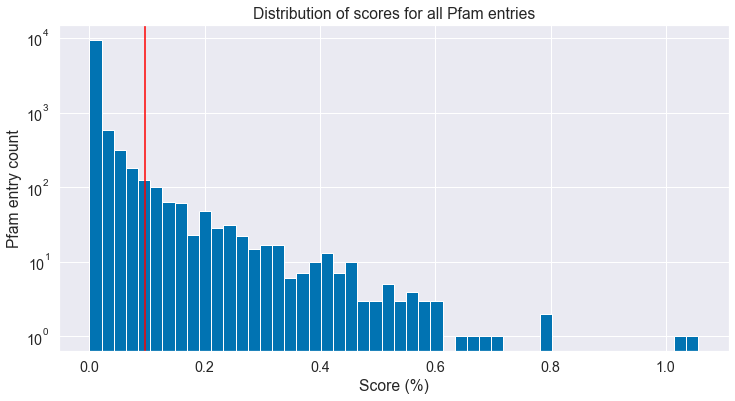

In [50]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(pfam_counts['score'].values, bins=50, log=True);
pfam_threshold = np.percentile(pfam_counts['score'].values, 95)
ax.axvline(pfam_threshold, color='red')
ax.set_xlabel('Score (%)')
ax.set_ylabel('Pfam entry count')
ax.set_title('Distribution of scores for all Pfam entries');

0.09701828073063584

In [24]:
%%time
tigr_counts = compute_protein_domain_score(engine, query_type='tigr')

2020-12-07 14:03:27,845 (INFO) Counting protein domains for 3,282 assemblies
2020-12-07 14:03:31,651 (INFO) 200 / 3,282
2020-12-07 14:03:35,309 (INFO) 400 / 3,282
2020-12-07 14:03:38,640 (INFO) 600 / 3,282
2020-12-07 14:03:41,973 (INFO) 800 / 3,282
2020-12-07 14:03:44,667 (INFO) 1,000 / 3,282
2020-12-07 14:03:47,189 (INFO) 1,200 / 3,282
2020-12-07 14:03:49,559 (INFO) 1,400 / 3,282
2020-12-07 14:03:51,417 (INFO) 1,600 / 3,282
2020-12-07 14:03:53,149 (INFO) 1,800 / 3,282
2020-12-07 14:03:54,717 (INFO) 2,000 / 3,282
2020-12-07 14:03:55,988 (INFO) 2,200 / 3,282
2020-12-07 14:03:57,172 (INFO) 2,400 / 3,282
2020-12-07 14:03:57,568 (INFO) 2,600 / 3,282
2020-12-07 14:03:57,575 (INFO) 2,800 / 3,282
2020-12-07 14:03:58,356 (INFO) 3,000 / 3,282
2020-12-07 14:03:59,967 (INFO) 3,200 / 3,282


CPU times: user 30.7 s, sys: 752 ms, total: 31.4 s
Wall time: 32.4 s


In [37]:
100 * len(tigr_counts[tigr_counts['score'] > 0.1]) / len(tigr_counts)

3.6013187927973624

In [26]:
tigr_query_to_most_common_label = compute_query_to_most_common_label(engine, query_type='tigr')

2020-12-07 14:04:00,269 (INFO) Finding most common protein labels per query for 3,282 assemblies
2020-12-07 14:04:01,223 (INFO) 200 / 3,282
2020-12-07 14:04:02,186 (INFO) 400 / 3,282
2020-12-07 14:04:03,026 (INFO) 600 / 3,282
2020-12-07 14:04:03,900 (INFO) 800 / 3,282
2020-12-07 14:04:04,585 (INFO) 1,000 / 3,282
2020-12-07 14:04:05,246 (INFO) 1,200 / 3,282
2020-12-07 14:04:05,907 (INFO) 1,400 / 3,282
2020-12-07 14:04:06,389 (INFO) 1,600 / 3,282
2020-12-07 14:04:06,881 (INFO) 1,800 / 3,282
2020-12-07 14:04:07,348 (INFO) 2,000 / 3,282
2020-12-07 14:04:07,736 (INFO) 2,200 / 3,282
2020-12-07 14:04:08,086 (INFO) 2,400 / 3,282
2020-12-07 14:04:08,212 (INFO) 2,600 / 3,282
2020-12-07 14:04:08,219 (INFO) 2,800 / 3,282
2020-12-07 14:04:08,455 (INFO) 3,000 / 3,282
2020-12-07 14:04:08,934 (INFO) 3,200 / 3,282


In [27]:
tigr_labels = [tigr_query_to_most_common_label[k] for k in tigr_counts.index]

In [28]:
tigr_counts['label'] = tigr_labels
tigr_counts.head(20)

,n_phylum,assembly_score_sum,assembly_count,assembly_count_top,score,label
tigr_query,,,,,,
TIGR00594,31,845.086076,1190,870,0.694401,"DNA-polymerase-III,-alpha-subunit"
TIGR00580,31,728.000000,1138,728,0.598192,transcription-repair-coupling-factor
TIGR00229,31,704.536214,1033,831,0.578912,PAS-domain-S-box-containing-protein
TIGR00630,31,694.991743,1209,722,0.571070,excinuclease-ABC-subunit-A
TIGR01494,31,644.297111,1182,918,0.529414,heavy-metal-translocating-P-type-ATPase
TIGR00593,31,611.000000,1181,611,0.502054,DNA-polymerase-I
TIGR00691,27,559.426407,1171,608,0.459677,GTP-pyrophosphokinase
TIGR01070,30,542.828427,964,543,0.446038,DNA-mismatch-repair-protein-MutS
TIGR02168,31,527.000000,906,527,0.433032,chromosome-segregation-protein-SMC


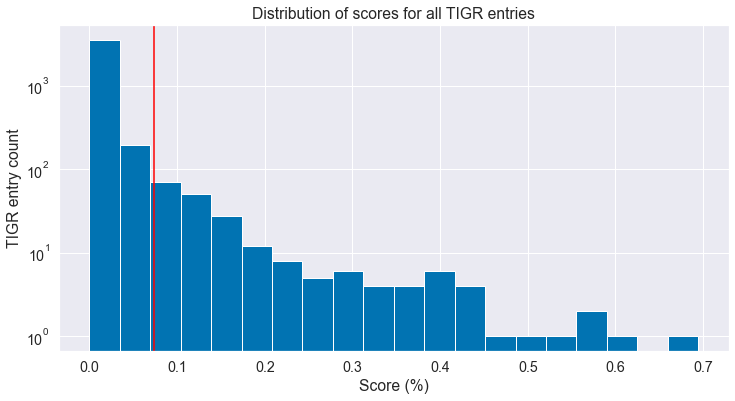

In [49]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(tigr_counts['score'].values, bins=20, log=True);
tigr_thresold = np.percentile(tigr_counts['score'].values, 95)
ax.axvline(tigr_thresold, color='red')
ax.set_xlabel('Score (%)')
ax.set_ylabel('TIGR entry count')
ax.set_title('Distribution of scores for all TIGR entries');

In [51]:
score_threshold = 0.05
base_path = os.path.join(os.getcwd(), 'data/domains/codon_bias/')
pfam_counts[pfam_counts['score'] >= pfam_threshold].to_excel(os.path.join(base_path, 'pfam_top.xlsx'))
tigr_counts[tigr_counts['score'] >= tigr_thresold].to_excel(os.path.join(base_path, 'tigr_top.xlsx'))

## Validation: Protein id match

Let's make sure IDs properly match and we are not simply seeing an artefact of proteins that joined

In [31]:
def check_protein_matching(engine, query_type):
    if query_type not in ('pfam', 'tigr'):
        raise ValueError('Query type must be one of (pfam, tigr)')
        
    q = """
    select assembly_accession from assembly_source
    """
    assembly_accessions = pd.read_sql(q, engine)['assembly_accession'].values
    
    logger.info(f'Checking {query_type} protein ID match for {len(assembly_accessions):,} assemblies')
    
    matching_scores = {}
    for i, assembly in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            logger.info(f'{i+1:,} / {len(assembly_accessions):,}')
            
        protein_domains_path = os.path.join(
            os.getcwd(), 
            f'data/domains/codon_bias/{query_type}/{assembly}_protein_domains.csv',
        )
        if not os.path.isfile(protein_domains_path):
            continue
        
        protein_domains = pd.read_csv(protein_domains_path)
        
        protein_query = """
        select metadata_json from sequences where sequence_type = 'CDS' and assembly_accession = ?
        """
        cds_metadata_df = pd.read_sql(protein_query, engine, params=(assembly,))
        metadata = [json.loads(v) for v in cds_metadata_df['metadata_json'].values if not pd.isnull(v)]
        
        cds_protein_ids = {
            m['protein_id'].strip() for m in metadata
            if m.get('protein_id') is not None
        }
        query_protein_ids = set([p.strip() for p in protein_domains['protein_id'].values if not pd.isnull(p)])
        
        matching_score = 100 * len(cds_protein_ids & query_protein_ids) / len(query_protein_ids)
        matching_scores[assembly] = matching_score
        
    return matching_scores

In [32]:
pfam_matching_scores = check_protein_matching(engine, query_type='pfam')

2020-12-07 14:04:10,201 (INFO) Checking pfam protein ID match for 3,282 assemblies
2020-12-07 14:04:18,377 (INFO) 200 / 3,282
2020-12-07 14:04:27,256 (INFO) 400 / 3,282
2020-12-07 14:04:35,071 (INFO) 600 / 3,282
2020-12-07 14:04:43,468 (INFO) 800 / 3,282
2020-12-07 14:04:50,303 (INFO) 1,000 / 3,282
2020-12-07 14:04:56,335 (INFO) 1,200 / 3,282
2020-12-07 14:05:02,157 (INFO) 1,400 / 3,282
2020-12-07 14:05:06,842 (INFO) 1,600 / 3,282
2020-12-07 14:05:11,228 (INFO) 1,800 / 3,282
2020-12-07 14:05:15,209 (INFO) 2,000 / 3,282
2020-12-07 14:05:18,400 (INFO) 2,200 / 3,282
2020-12-07 14:05:21,498 (INFO) 2,400 / 3,282
2020-12-07 14:05:22,629 (INFO) 2,600 / 3,282
2020-12-07 14:05:22,635 (INFO) 2,800 / 3,282
2020-12-07 14:05:24,594 (INFO) 3,000 / 3,282
2020-12-07 14:05:28,438 (INFO) 3,200 / 3,282


In [33]:
tigr_matching_scores = check_protein_matching(engine, query_type='tigr')

2020-12-07 14:05:29,092 (INFO) Checking tigr protein ID match for 3,282 assemblies
2020-12-07 14:05:36,206 (INFO) 200 / 3,282
2020-12-07 14:05:44,101 (INFO) 400 / 3,282
2020-12-07 14:05:50,840 (INFO) 600 / 3,282
2020-12-07 14:05:58,058 (INFO) 800 / 3,282
2020-12-07 14:06:03,764 (INFO) 1,000 / 3,282
2020-12-07 14:06:09,050 (INFO) 1,200 / 3,282
2020-12-07 14:06:14,001 (INFO) 1,400 / 3,282
2020-12-07 14:06:18,021 (INFO) 1,600 / 3,282
2020-12-07 14:06:21,759 (INFO) 1,800 / 3,282
2020-12-07 14:06:25,215 (INFO) 2,000 / 3,282
2020-12-07 14:06:27,934 (INFO) 2,200 / 3,282
2020-12-07 14:06:30,548 (INFO) 2,400 / 3,282
2020-12-07 14:06:31,517 (INFO) 2,600 / 3,282
2020-12-07 14:06:31,524 (INFO) 2,800 / 3,282
2020-12-07 14:06:33,182 (INFO) 3,000 / 3,282
2020-12-07 14:06:36,440 (INFO) 3,200 / 3,282


In [34]:
outlier_threshold = 90
outlier_assemblies = {a for a in pfam_matching_scores.keys() if pfam_matching_scores[a] < outlier_threshold}
outlier_assemblies |= {a for a in tigr_matching_scores.keys() if tigr_matching_scores[a] < outlier_threshold}
len(outlier_assemblies)

33

In [35]:
sorted(outlier_assemblies)

['GCA_000011225.1',
 'GCA_000011445.1',
 'GCA_000012765.1',
 'GCA_000063605.1',
 'GCA_000092585.1',
 'GCA_000183365.1',
 'GCA_000183385.1',
 'GCA_000195875.1',
 'GCA_000328725.1',
 'GCA_000400935.1',
 'GCA_000400955.1',
 'GCA_000439435.1',
 'GCA_000439455.1',
 'GCA_000500935.1',
 'GCA_000565175.1',
 'GCA_000565215.1',
 'GCA_001029265.1',
 'GCA_001262715.1',
 'GCA_001267155.1',
 'GCA_001274875.1',
 'GCA_001281045.1',
 'GCA_001715535.1',
 'GCA_001886855.1',
 'GCA_001900245.1',
 'GCA_001998865.1',
 'GCA_002163585.1',
 'GCA_002237575.1',
 'GCA_002803985.1',
 'GCA_002804105.1',
 'GCA_002813555.1',
 'GCA_002865545.1',
 'GCA_003339775.1',
 'GCA_003363775.1']

In [55]:
q = """
select a.assembly_accession, s.species_taxid, s.species, s.phylum from assembly_source as a
left join species_traits as s on s.species_taxid = a.species_taxid
"""
df = pd.read_sql(q, engine, index_col='assembly_accession')
ix = set(df.index.tolist()) - set(outlier_assemblies)
phyla = df.loc[ix]['phylum'].unique()
len(phyla)

36

In [56]:
df[df['phylum'].isnull()]

,species_taxid,species,phylum
assembly_accession,,,
GCA_000025005.1,166501,Thermobaculum terrenum,None


## Top Gene Ontology (GO) categories

In [107]:
pfam2go_path = os.path.join(os.getcwd(), 'data/domains/Pfam2go.txt')
pfam_results = pd.read_excel(
    os.path.join(os.getcwd(), f'data/domains/codon_bias/pfam_top.xlsx'),
    index_col='pfam_query',
)

In [108]:
def parse_pfam_to_go_file(path):
    line_re = r'^Pfam:([^\s]+) ([^>]+) > GO:([^;]+) ; GO:([0-9]+)$'
    domain_to_go = collections.defaultdict(list)
    with open(path, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith('!'):
                continue
                
            m = re.match(line_re, line)
            if m:
                pfam_id = m[1].strip()
                query =  m[2].strip()
                go_label = m[3].strip()
                go_id = m[4].strip()
                
                domain_to_go[query].append((go_id, go_label))
                
    return dict(domain_to_go)

In [109]:
domain_to_go = parse_pfam_to_go_file(pfam2go_path)

In [9]:
domain_to_go['Helicase_C_2']

NameError: name 'domain_to_go' is not defined

In [111]:
def compute_top_go_categories(pfam_results, domain_to_go):
    data = {
        'go_id': [],
        'go_label': [],
        'count': [],
    }
    matching = 0
    go_id_count = collections.defaultdict(int)
    go_id_to_label = {}
    for domain in pfam_results.index:
        if domain not in domain_to_go:
            continue
        else:
            matching += 1
            
        go_data = domain_to_go[domain]
        
        for go_id, go_label in go_data:
            go_id_count[go_id] += 1
            go_id_to_label[go_id] = go_label
            
    for go_id in sorted(go_id_count.keys()):
        data['go_id'].append(go_id)
        data['go_label'].append(go_id_to_label[go_id])
        data['count'].append(go_id_count[go_id])
            
    print(f'{matching} / {len(pfam_results)} ({100 * matching / len(pfam_results):.0f}%) matching domains with go')
    
    return pd.DataFrame.from_dict(data).set_index('go_id').sort_values('count', ascending=False)

In [112]:
go_df = compute_top_go_categories(pfam_results, domain_to_go)
go_df.head(20)

245 / 553 (44%) matching domains with go


,go_label,count
go_id,,
0005524,ATP binding,53
0003677,DNA binding,26
0055114,oxidation-reduction process,26
0005975,carbohydrate metabolic process,21
0016491,oxidoreductase activity,15
0003824,catalytic activity,14
0005515,protein binding,13
0003899,DNA-directed 5'-3' RNA polymerase activity,11
0006351,"transcription, DNA-templated",11


In [153]:
go_df.to_excel(os.path.join(os.getcwd(), 'data/domains/codon_bias/go_labels.xlsx'))

## tRNA adaptation index

In [116]:
trnai = pd.read_csv(os.path.join(os.getcwd(), 'data/trn_adaptation_index/GCA_000005825.2_tai.csv'))
trnai.head()

,assembly_accession,species_taxid,row_id,protein_id,protein,gene,adaptation_index
0,GCA_000005825.2,79885,253459,ADC51616.1,hypothetical protein,NaN,1.000000
1,GCA_000005825.2,79885,252123,ADC50280.1,hypothetical protein,NaN,0.901509
2,GCA_000005825.2,79885,252052,ADC50209.1,hypothetical protein,NaN,0.898870
3,GCA_000005825.2,79885,253277,ADC51434.1,cold-shock DNA-binding protein family protein,cspC3,0.871788
4,GCA_000005825.2,79885,253078,ADC51235.1,hypothetical protein,NaN,0.842573


In [150]:
def score_fn(trnai):
    mean = trnai['adaptation_index'].mean()
    std = trnai['adaptation_index'].std()
    
    def fn(adaptation_index):
        if adaptation_index > mean + std:
            return 'over expressed'
        elif adaptation_index < mean - std:
            return 'under expressed'
        else:
            return 'normally expressed'
    
    return fn

In [151]:
trnai['expression'] = trnai['adaptation_index'].apply(score_fn(trnai))
trnai.head()

,assembly_accession,species_taxid,row_id,protein_id,protein,gene,adaptation_index,percentile,expression
0,GCA_000005825.2,79885,253459,ADC51616.1,hypothetical protein,NaN,1.000000,100,over expressed
1,GCA_000005825.2,79885,252123,ADC50280.1,hypothetical protein,NaN,0.901509,100,over expressed
2,GCA_000005825.2,79885,252052,ADC50209.1,hypothetical protein,NaN,0.898870,100,over expressed
3,GCA_000005825.2,79885,253277,ADC51434.1,cold-shock DNA-binding protein family protein,cspC3,0.871788,100,over expressed
4,GCA_000005825.2,79885,253078,ADC51235.1,hypothetical protein,NaN,0.842573,100,over expressed


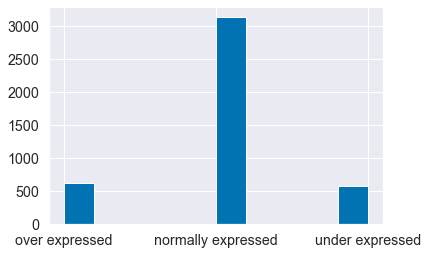

In [155]:
trnai['expression'].hist();

## AAA domains scale in numbers with genome size

How does it affect our scoring? 

In [4]:
species_traits = pd.read_sql(
    'select species_taxid, species, genome_size from species_traits', 
    engine,
    index_col='species_taxid',
)
species_traits.head()

,species,genome_size
species_taxid,,
7,Azorhizobium caulinodans,5369771.500
9,Buchnera aphidicola,601699.243
11,Cellulomonas gilvus,3526440.800
14,Dictyoglomus thermophilum,1959987.600
19,Pelobacter carbinolicus,3722544.667


In [5]:
species_traits.loc[[2336]]

,species,genome_size
species_taxid,,
2336,Thermotoga maritima,1865969.5


In [6]:
thermotoga_maritima_domains = compute_protein_domain_scores(engine, ['GCA_000008545.1'], 'pfam')
aaa_domains = sorted([d for d in thermotoga_maritima_domains.index if 'AAA' in d])
thermotoga_maritima_domains.loc[aaa_domains].sort_values('score', ascending=False)

,assembly_score_sum,assembly_count,assembly_count_top,score
pfam_query,,,,
AAA_assoc_2,1.000000,1,1,1.000000
AAA_PrkA,1.000000,1,1,1.000000
AAA_32,1.000000,1,1,1.000000
AAA_27,0.250000,2,1,0.250000
AAA_3,0.111111,3,1,0.111111
AAA_5,0.092239,13,3,0.092239
AAA_15,0.062500,4,1,0.062500
AAA,0.060491,23,4,0.060491
AAA_23,0.040000,5,1,0.040000


## Count unique Pfam

In [5]:
%%time
import pathlib
pfam_folder = '/Users/srom/workspace/rna_learn/data/domains/tri_nucleotide_bias/pfam'

protein_domains = set()
paths = pathlib.Path(pfam_folder).glob('*.csv')
for p in paths:
    with p.open() as f:
        df = pd.read_csv(f)
        protein_domains |= set(df['pfam_query'].unique())
        
print(len(protein_domains))

11087
CPU times: user 12.3 s, sys: 2.11 s, total: 14.4 s
Wall time: 15.8 s


In [6]:
n_pfam_domains = len(protein_domains)

In [12]:
100 * 240 / n_pfam_domains

2.1646973933435554